#A Brief Guide of Using Hybrid Monte Carlo for Gaussian Process Models

### Zhenwen Dai and Mu Niu, November 2014

In [1]:
import numpy as np
import GPy
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from pylab import *

## Example 1  HMC Inference for GP Regression

Let's first generate some synthetic data.

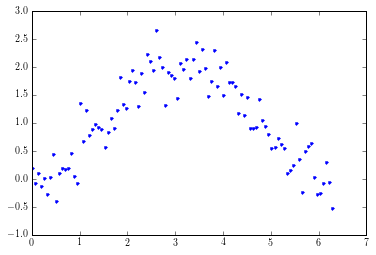

In [2]:
# Let's make some synthetic data
x = np.linspace(0.,2*np.pi,100)[:,None]
y = -cos(x)+np.random.randn(*x.shape)*0.3+1
_ = plot(x,y,'.')

Let us Make a GP Regression model and give some general prior distributions to model parameters.

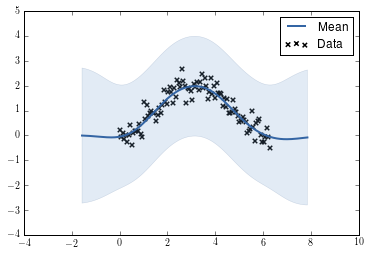

In [3]:
# Make a GP regression model
m = GPy.models.GPRegression(x,y)
# Give some general prior distributions for model parameters
m.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
_=m.plot()

###Sampling the posterior distribution of model parameters

Draw 1000 samples from the GP model

In [4]:
hmc = GPy.inference.mcmc.HMC(m,stepsize=5e-2)
s = hmc.sample(num_samples=1000)

Plot the samples:

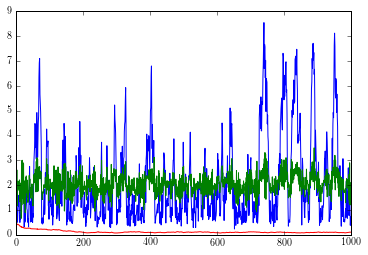

In [5]:
plot(s)

Plot the posterior marginal distribution of model parameters:

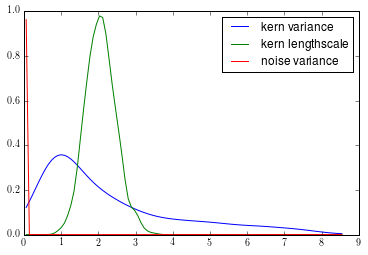

In [6]:
labels = ['kern variance', 'kern lengthscale','noise variance']
samples = s[300:] # cut out the burn-in period
from scipy import stats
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin,xmax,100)
for i in xrange(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()

Plot the model parameters (lengthscale, variance and noise variance) against each other:

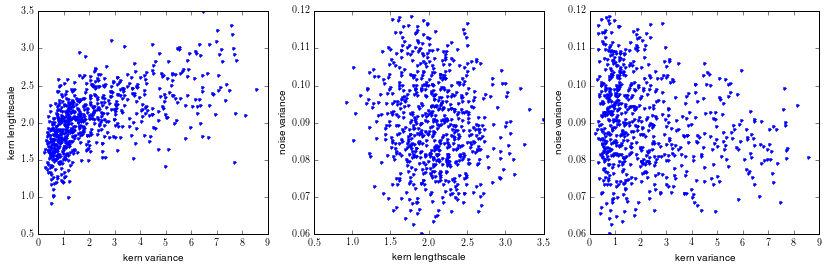

In [7]:
fig = figure(figsize=(14,4))
ax = fig.add_subplot(131)
_=ax.plot(samples[:,0],samples[:,1],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[1])
ax = fig.add_subplot(132)
_=ax.plot(samples[:,1],samples[:,2],'.')
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[2])
ax = fig.add_subplot(133)
_=ax.plot(samples[:,0],samples[:,2],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[2])

By setting the model parameters to the posterior mean, we can visualize the model fit:


Name : GP regression
Objective : 44.0091857406
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |            value  |  constraints  |     priors   
  rbf.variance             |    2.24202451266  |      +ve      |  Ga(0.1, 0.1)
  rbf.lengthscale          |    2.06394427222  |      +ve      |  Ga(0.1, 0.1)
  Gaussian_noise.variance  |  0.0901697007401  |      +ve      |  Ga(0.1, 0.1)


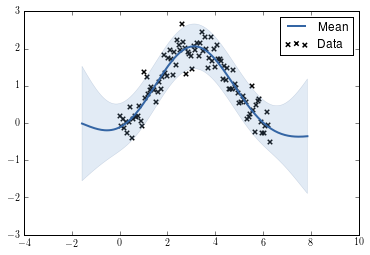

In [8]:
# Set the model parameters as the posterior mean
m.kern.variance[:] = samples[:,0].mean()
m.kern.lengthscale[:] = samples[:,1].mean()
m.likelihood.variance[:] = samples[:,2].mean()
print m
_=m.plot()

###Sample the posterior distribution of X given some new Y

Given some new observations, inferring the posterior distribution of the corresponding inputs is difficult, because it can lead to multi-modal distributions. 

Assume we have a new observation $1.5$, and try to infer its input distribution.

In [9]:
y_new = np.array([1.5])[:,None]

Generate the inference model for the new observations. X_new are the MAP estimations by optimizing the log likelihood. As plotted with a red dot, the MAP estimation corresponds to only one of the modes.


Name : inferenceX
Objective : -12.4561908554
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  inferenceX.  |          value  |  constraints  |  priors
  latent mean  |  [ 4.26150129]  |               |        


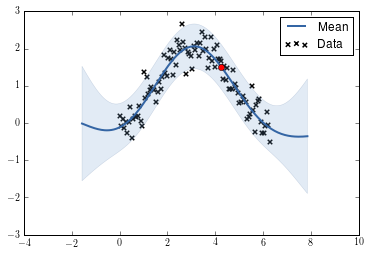

In [10]:
x_new,mi = m.infer_newX(y_new)
print mi
m.plot()
plot(x_new,y_new,'or')

Draw 10,000 samples from the inference model:

In [11]:
hmc_new = GPy.inference.mcmc.HMC(mi,stepsize=2e-1)
s_new = hmc_new.sample(num_samples=10000,hmc_iters=10)

Plot the samples:

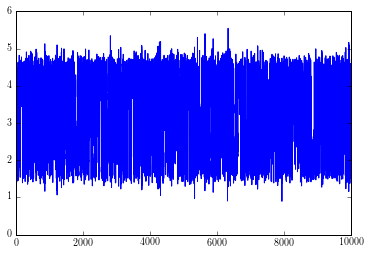

In [12]:
_ = plot(s_new[:,:])

Plot the marginal distribution of inferred inputs. The two modes of inputs are clearly visible from the sampled posterior distribution.

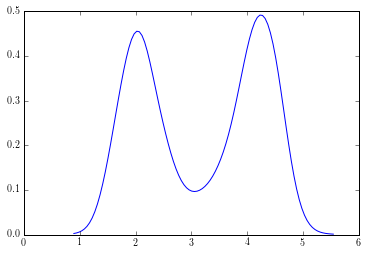

In [13]:
from scipy import stats
samples_new = s_new[:]
xmin = samples_new.min()
xmax = samples_new.max()
xs = np.linspace(xmin,xmax,100)
for i in xrange(samples_new.shape[1]):
    kernel = stats.gaussian_kde(samples_new[:,i])
    plot(xs,kernel(xs))

# Example 2 HMC for lengthscale and variance with marathon data

##### we set prior for lengthscale and variance of kernel. The mean of the prior is close to the result of GP optimisation. we then allow a big variance. In the case below,we set gamma prior to lengthscale and variance. E(lengthscale) = 120, Var(lengthscale)=2000, E(variance) = 25, Var(variance) = 150 


Name : GP regression
Objective : 15.5939533439
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |            value  |  constraints  |     priors    
  rbf.variance             |    25.3995048123  |      +ve      |  Ga(4.2, 0.17)
  rbf.lengthscale          |    152.045313268  |      +ve      |  Ga(7.2, 0.06)
  Gaussian_noise.variance  |  0.0485064747583  |      +ve      |               


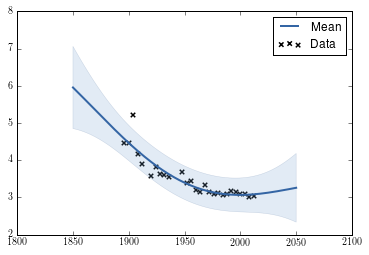

In [14]:
m = GPy.examples.regression.olympic_marathon_men()
#
#set prior for lengthscale and variance.
m.kern.variance.set_prior(GPy.priors.Gamma.from_EV(25.,150.))
m.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(120.,2000.))
print m

### Run HMC

##### we plot the full length of hmc iteration. The first 5000 could be burn in stage and can be ignored. 

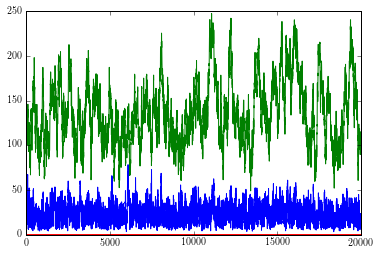

In [15]:
# initialise hmc
hmc = GPy.inference.mcmc.HMC(m,stepsize=2e-1)
# run hmc
t = hmc.sample(num_samples=20000,hmc_iters=20)

# Sample parameters 
#hmc = GPy.inference.optimization.HMC(m, stepsize=5e-1)
#t = hmc.sample(m_iters=50000,hmc_iters=20)

_=plot(t)

[  2.39637898e+01   1.35983726e+02   5.28534761e-02]
[  9.98687562e+00   3.54399556e+01   1.62715914e-02]


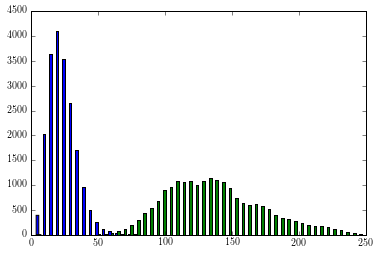

In [16]:
print t.mean(axis=0)
print t.std(axis=0)
_=hist(t[:,:2],50)

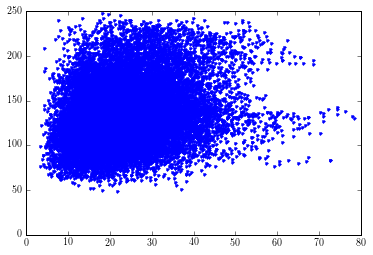

In [17]:
_=plot(t[:,0],t[:,1],'.')